In [3]:
import numpy as np
import time
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import roc_curve, auc

# Neural Network

Step-by-Step implementation of a neural network that will later be trained on the MNIST dataset.



### Class NeuralNetwork:

- **init:** The constructor initializes an instance of the `NeuralNetwork` class with specified layer sizes and activation functions. By default, activations are set to sigmoid functions for all layers.

- **initialize:** This method initializes the neural network parameters such as weights and biases, randomly sampling them from a normal distribution.

- **forward:** Performs forward propagation for the input data `x`, calculating outputs at each layer using the current weights and biases.

- **backward:** Executes backpropagation for input `x`, computing loss gradients for each network parameter to update weights and biases during training.

- **optimize:** Updates the network’s weights and biases by applying gradient-based optimization to minimize the loss function.

- **train:** Trains the neural network model on training data `x_train` and labels `y_train` for a specified number of epochs and batch size, using forward and backward propagation. At the end of each epoch, metrics such as accuracy, sensitivity, specificity, and execution time are displayed.


In [4]:
class NeuralNetwork():

    def __init__(self, sizes, activations=None):
        self.sizes = sizes
        if activations is None:
            activations = ['sigmoid'] * (len(sizes) - 1)

        self.activations = []
        self.activation_derivatives = []
        for activation in activations:
            if activation == 'relu':
                self.activations.append(self.relu)
                self.activation_derivatives.append(self.relu_derivative)
            else:
                self.activations.append(self.sigmoid)
                self.activation_derivatives.append(self.sigmoid_derivative)

        self.params = self.initialize()
        self.cache = {}

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x <= 0, 0, 1)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def initialize(self):
        params = {}
        for i in range(1, len(self.sizes)):
            input_size = self.sizes[i-1]
            output_size = self.sizes[i]

            params[f"W{i}"] = np.random.randn(output_size, input_size) * np.sqrt(1. / input_size)
            params[f"b{i}"] = np.zeros((output_size, 1))

        return params

    def forward(self, x):
        self.cache["X"] = x
        self.cache["A0"] = x.T
        for i in range(1, len(self.sizes)):
            z = np.dot(self.params[f"W{i}"], self.cache[f"A{i-1}"]) + self.params[f"b{i}"]
            self.cache[f"Z{i}"] = z
            if i == len(self.sizes) - 1:
                self.cache[f"A{i}"] = self.sigmoid(z)
            else:
                self.cache[f"A{i}"] = self.activations[i-1](z)
        return self.cache[f"A{len(self.sizes)-1}"]


    def backward(self, y, output):
        current_batch_size = y.shape[0]
        grads = {}

        Z = output - y.T
        for i in range(len(self.sizes)-1, 0, -1):
            if i == len(self.sizes) - 1:
                W = (1. / current_batch_size) * np.dot(Z, self.cache[f"A{i-1}"].T)
                b = (1. / current_batch_size) * np.sum(Z, axis=1, keepdims=True)
            else:
                Z = np.dot(self.params[f"W{i+1}"].T, Z) * self.activation_derivatives[i-1](self.cache[f"Z{i}"])
                W = (1. / current_batch_size) * np.dot(Z, self.cache[f"A{i-1}"].T)
                b = (1. / current_batch_size) * np.sum(Z, axis=1, keepdims=True)
            grads[f"W{i}"] = W
            grads[f"b{i}"] = b

        self.grads = grads
        return grads

    def optimize(self, l_rate=0.1):
        for key in self.params:
            self.params[key] = self.params[key] - l_rate * self.grads[key]

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def confusion_matrix(self, x, y):
        predictions = self.predict(x)
        return confusion_matrix(np.argmax(y, axis=-1), predictions)

    def sensitivity_specificity(self, confusion_matrix):
        num_classes = confusion_matrix.shape[0]

        if num_classes == 2:
            true_positive = confusion_matrix[1, 1]
            false_positive = confusion_matrix[0, 1]
            false_negative = confusion_matrix[1, 0]
            true_negative = confusion_matrix[0, 0]

            sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
            specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0
        else:
            sensitivity = np.zeros(num_classes)
            specificity = np.zeros(num_classes)

            for i in range(num_classes):
                true_positive = confusion_matrix[i, i]
                false_positive = np.sum(confusion_matrix[:, i]) - true_positive
                false_negative = np.sum(confusion_matrix[i, :]) - true_positive
                true_negative = np.sum(confusion_matrix) - true_positive - false_positive - false_negative

                sensitivity[i] = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
                specificity[i] = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

            sensitivity = np.mean(sensitivity)
            specificity = np.mean(specificity)

        return sensitivity, specificity

    def predict(self, x):
        output = self.forward(x)
        predictions = np.argmax(output, axis=0)
        return predictions

    def train(self, x_train, y_train, x_test, y_test, epochs=10,
              batch_size=64, l_rate=0.1):
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)

        for i in range(self.epochs):
            start_time = time.time()
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]

                output = self.forward(x)
                grad = self.backward(y, output)
                self.optimize(l_rate=l_rate)

            output = self.forward(x_test)
            test_acc = self.accuracy(y_test, output)
            confusion = self.confusion_matrix(x_test, y_test)
            sensitivity, specificity = self.sensitivity_specificity(confusion)

            print(f"Epoch {i+1}: Test accuracy: {test_acc:.4f} "
                  f"Sensitivity: {sensitivity:.4f} Specificity: {specificity:.4f} "
                  f"Time: {time.time()-start_time:.2f} sec ")

        confusion = self.confusion_matrix(x_test, y_test)
        print("")
        print("Confusion matrix after all epochs:")
        print("")
        print(confusion)

In [5]:
def one_hot(x, k, dtype=np.float32):
    x = np.array(x)
    return np.array(x[:, None] == np.arange(k), dtype)

Functions that allow us to easily visualize the generated images.

In [6]:
def show_images(image, num_row=2, num_col=5):
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Loading and normalization of data:


In [7]:
mnist_data = fetch_openml("mnist_784")
x = mnist_data["data"]
y = mnist_data["target"]

x /= 255.0

num_labels = 10
y_new = one_hot(y.astype('int32'), num_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y_new, test_size=0.3, shuffle=True)

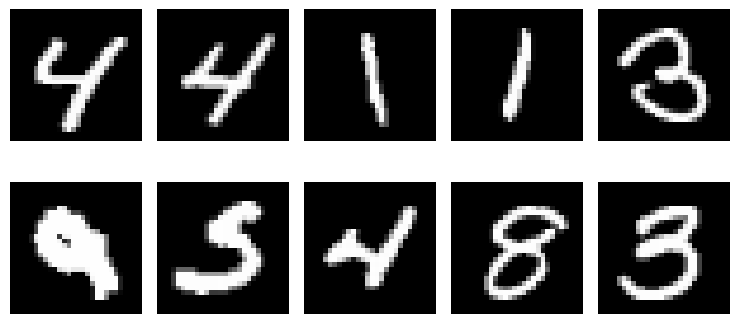

In [8]:
show_images(x_train)

Let's move on to creating a 5-layer neural network with custom activation functions for each layer (specifically, ReLU and sigmoid).


In [9]:
x_train_values = x_train.values
nn = NeuralNetwork([784, 128, 64, 32, 16, 10], activations=['relu', 'sigmoid', 'relu', 'sigmoid', 'relu'])
nn.train(x_train_values, y_train, x_test, y_test, batch_size=128, l_rate=0.1)

Epoch 1: Test accuracy: 0.3905 Sensitivity: 0.3798 Specificity: 0.9321 Time: 13.56 sec 
Epoch 2: Test accuracy: 0.4865 Sensitivity: 0.4778 Specificity: 0.9428 Time: 3.76 sec 
Epoch 3: Test accuracy: 0.6594 Sensitivity: 0.6551 Specificity: 0.9622 Time: 3.24 sec 
Epoch 4: Test accuracy: 0.8299 Sensitivity: 0.8272 Specificity: 0.9811 Time: 3.20 sec 
Epoch 5: Test accuracy: 0.8843 Sensitivity: 0.8831 Specificity: 0.9872 Time: 7.49 sec 
Epoch 6: Test accuracy: 0.9105 Sensitivity: 0.9100 Specificity: 0.9901 Time: 3.50 sec 
Epoch 7: Test accuracy: 0.9307 Sensitivity: 0.9301 Specificity: 0.9923 Time: 3.33 sec 
Epoch 8: Test accuracy: 0.9347 Sensitivity: 0.9344 Specificity: 0.9928 Time: 5.29 sec 
Epoch 9: Test accuracy: 0.9325 Sensitivity: 0.9322 Specificity: 0.9925 Time: 3.32 sec 
Epoch 10: Test accuracy: 0.9497 Sensitivity: 0.9494 Specificity: 0.9944 Time: 3.19 sec 

Confusion matrix after all epochs:

[[1993    0    5    2    0    9    7    5    6    0]
 [   0 2244   11    8    3    0    2  

As we can see, the trained neural network performs excellently.
